In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')
sns.set()

## Target 
* Forecast daily traffic for D+1 to D+7

Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2015-2018.
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

## Plan
1. Download raw data
2. Verify the data are time series. If not, bring them to time series with the required frequency
3. Exploratory data analysis - understand what data tells us
4. Handle missing values
5. Encode categorical variables
6. Features Engineering (based on date and target itself)
7. Baseline model - Naive Forecast
8. Prepare framework for models training using walk forward validation
9. Models training and validation

# Download the raw data

In [2]:
raw_df = pd.read_csv('metro_data.csv')
raw_df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [3]:
raw_df.tail()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
32228,2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543
32229,2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
32230,2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159
32231,2018-09-30 22:00:00,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450
32232,2018-09-30 23:00:00,None,282.12,0.0,0.0,90,Clouds,overcast clouds,954


In [4]:
raw_df.shape

(32233, 9)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32233 entries, 0 to 32232
Data columns (total 9 columns):
date_time              32233 non-null object
holiday                32233 non-null object
temp                   32233 non-null float64
rain_1h                32233 non-null float64
snow_1h                32233 non-null float64
clouds_all             32233 non-null int64
weather_main           32233 non-null object
weather_description    32233 non-null object
traffic_volume         32233 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.2+ MB


In [6]:
raw_df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,32233.000000,32233.000000,32233.000000,32233.000000,32233.000000
mean,282.955665,0.420472,0.000333,47.290293,3258.114851
std,12.120323,54.766368,0.009986,39.734834,1973.534323
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,273.940000,0.000000,0.000000,1.000000,1196.000000
50%,285.190000,0.000000,0.000000,40.000000,3412.000000
75%,292.750000,0.000000,0.000000,90.000000,4912.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


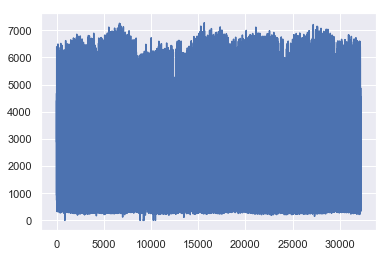

In [7]:
plt.plot(raw_df['traffic_volume'])
plt.show()

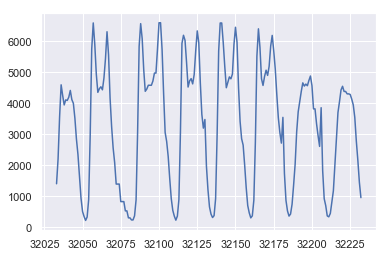

In [8]:
plt.plot(raw_df['traffic_volume'].tail(200));

# Verify data are time series
* the only column considered as a time index
* the column is sorted
* the column has stable frequency

1. The only column is considered as a time index - __date_time__

In [9]:
df = raw_df.set_index('date_time')
df.index = pd.to_datetime(df.index)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


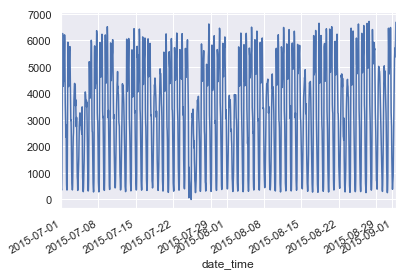

In [10]:
df.loc['2015-07-01':'2015-09-01', 'traffic_volume'].plot()

## Task 1
* implement transformer __MakeTSTransformer__ which makes the dataset timeseries

In [11]:

class MakeTSTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, date_column):
        self.date_column = date_column
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X = X.set_index(self.date_column)
        X.index = pd.to_datetime(X.index)
        return X
    
ts_transformer = MakeTSTransformer(date_column='date_time')
ts_transformer.fit(raw_df)
ts_transformer.transform(raw_df).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


2. Column is __sorted__


In [15]:
# if sorted column is equal to the orginal column, it means the column is sorted properly
(df.index == df.index.sort_values()).all()

# if not, then we can sort it 
# df = df.sort_index()

True

3. Stable __frequency__

In [16]:
# difference between all rows is 1H (1D etc)
print(pd.infer_freq(df.index))

None


### Conclusion: the data are not time series. Modifications are required including resampling to daily data.

# Exploratory Data Analysis
Here we need to decide which columns we can remove and what to do with other columns.

In [17]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [18]:
cat_columns = df.select_dtypes(exclude=np.number).columns.tolist()
cat_columns

['holiday', 'weather_main', 'weather_description']

In [19]:
# values for category columns
for col in cat_columns:
    print(f'{col}: {df[col].nunique()}')
    print(df[col].unique())
    print()

holiday: 12
['None' 'Independence Day' 'State Fair' 'Labor Day' 'Columbus Day'
 'Veterans Day' 'Thanksgiving Day' 'Christmas Day' 'New Years Day'
 'Washingtons Birthday' 'Memorial Day' 'Martin Luther King Jr Day']

weather_main: 11
['Rain' 'Clear' 'Clouds' 'Haze' 'Thunderstorm' 'Mist' 'Fog' 'Drizzle'
 'Smoke' 'Snow' 'Squall']

weather_description: 37
['light rain' 'Sky is Clear' 'sky is clear' 'broken clouds' 'few clouds'
 'scattered clouds' 'moderate rain' 'haze' 'proximity thunderstorm' 'mist'
 'fog' 'heavy intensity rain' 'drizzle' 'thunderstorm'
 'light intensity drizzle' 'overcast clouds'
 'thunderstorm with heavy rain' 'very heavy rain' 'smoke'
 'proximity shower rain' 'thunderstorm with light rain'
 'proximity thunderstorm with drizzle' 'thunderstorm with rain'
 'thunderstorm with light drizzle' 'heavy intensity drizzle'
 'proximity thunderstorm with rain' 'light rain and snow' 'light snow'
 'snow' 'heavy snow' 'light intensity shower rain'
 'thunderstorm with drizzle' 'SQUALLS'

## Weather

In [20]:
for value in df['weather_main'].unique():
    weather_descr = df[df['weather_main']==value]['weather_description'].unique()
    print(f'{value} : {weather_descr}')
    print()

Rain : ['light rain' 'moderate rain' 'heavy intensity rain' 'very heavy rain'
 'proximity shower rain' 'light intensity shower rain' 'freezing rain']

Clear : ['Sky is Clear' 'sky is clear']

Clouds : ['broken clouds' 'few clouds' 'scattered clouds' 'overcast clouds']

Haze : ['haze']

Thunderstorm : ['proximity thunderstorm' 'thunderstorm' 'thunderstorm with heavy rain'
 'thunderstorm with light rain' 'proximity thunderstorm with drizzle'
 'thunderstorm with rain' 'thunderstorm with light drizzle'
 'proximity thunderstorm with rain' 'thunderstorm with drizzle']

Mist : ['mist']

Fog : ['fog']

Drizzle : ['drizzle' 'light intensity drizzle' 'heavy intensity drizzle'
 'shower drizzle']

Smoke : ['smoke']

Snow : ['light rain and snow' 'light snow' 'snow' 'heavy snow'
 'light shower snow' 'sleet']

Squall : ['SQUALLS']



In [ ]:
# haze => mgła
# mist => zamglenie, mgła
# fog => mgła
# drizzle => mżawka
# squall => szkwał

Weather description is just extension of 'weather_main' thus it can be removed. Let's consider the __'weather_main'__.

In [21]:
df['weather_main'].value_counts()

Clear           9656
Clouds          8594
Mist            4191
Rain            3853
Snow            1926
Drizzle         1454
Haze             993
Thunderstorm     846
Fog              699
Smoke             20
Squall             1
Name: weather_main, dtype: int64

In [22]:
df['weather_main'].value_counts() / df.shape[0] * 100

Clear           29.956876
Clouds          26.662116
Mist            13.002203
Rain            11.953588
Snow             5.975243
Drizzle          4.510905
Haze             3.080694
Thunderstorm     2.624639
Fog              2.168585
Smoke            0.062048
Squall           0.003102
Name: weather_main, dtype: float64

We need to group the categories with low frequency (e.g., Squall, Smoke etc.). Threshold to be set.

In [23]:
# precipitation - rain
(df['rain_1h'].value_counts() / df.shape[0] * 100).head()

0.00    94.021655
0.25     1.405392
0.51     0.434337
0.30     0.291627
1.02     0.276115
Name: rain_1h, dtype: float64

In [24]:
# snow
(df['snow_1h'].value_counts() / df.shape[0] * 100).head()

0.00    99.804548
0.05     0.043434
0.06     0.037229
0.10     0.018614
0.13     0.018614
Name: snow_1h, dtype: float64

In [25]:
# clouds
(df['clouds_all'].value_counts() / df.shape[0] * 100).head(10)

90    35.119288
1     30.595973
75    11.339311
40     9.490274
5      3.242019
20     3.155152
0      2.947290
92     0.915211
8      0.412621
12     0.394006
Name: clouds_all, dtype: float64

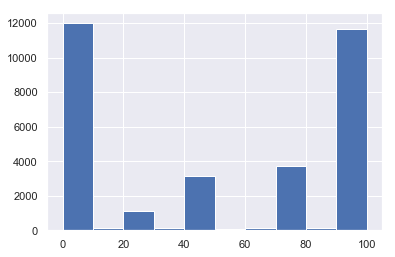

In [26]:
df['clouds_all'].hist()

## Holiday

In [27]:
df['holiday'].unique()

array(['None', 'Independence Day', 'State Fair', 'Labor Day',
       'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Martin Luther King Jr Day'], dtype=object)

In [28]:
df['holiday'].value_counts()

None                         32190
Labor Day                        6
Martin Luther King Jr Day        5
Christmas Day                    4
New Years Day                    4
Independence Day                 4
Thanksgiving Day                 4
State Fair                       4
Veterans Day                     3
Memorial Day                     3
Washingtons Birthday             3
Columbus Day                     3
Name: holiday, dtype: int64

In [29]:
holiday_dates = df.holiday[df.holiday != 'None'].index
holiday_dates

DatetimeIndex(['2015-07-03', '2015-08-27', '2015-09-07', '2015-10-12',
               '2015-11-11', '2015-11-26', '2015-11-26', '2015-12-25',
               '2016-01-01', '2016-01-01', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-08-25', '2016-09-05', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2016-12-26', '2017-01-02', '2017-01-16', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-08-24',
               '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23',
               '2017-12-25', '2018-01-01', '2018-01-15', '2018-01-15',
               '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04',
               '2018-08-23', '2018-09-03', '2018-09-03'],
              dtype='datetime64[ns]', name='date_time', freq=None)

## Conclusion:
1. Holiday => to be turned to binary value.
2. 'Weather_main' => categories to be reduced based on the 10% threshold to reduce dimensionality.
3. __Columns to remove__:
    - 'rain_1h' - low variance, redundant;
    - 'snow_1h' - very low variance, redundant;
    - 'clouds_all' - redundant,not meaningful;
    - 'weather_description' - redundant.

## Task 2
* implement transformer for columns dropping
* implement pipeline with MakeTSTransfomer and columns dropping transfomer

In [31]:


class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [32]:
 

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']))
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)



Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']))])

In [33]:
pipeline.transform(raw_df).head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,None,287.586,Rain,2886
2015-06-12 18:00:00,None,297.543,Clear,4380
2015-06-12 20:00:00,None,292.061,Clear,3095
2015-06-12 21:00:00,None,292.061,Clear,3299
2015-06-13 21:00:00,None,294.840,Clouds,3040


## Task 3
* implement transformer which will turn holiday into binary column

In [34]:
class HolidayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.holiday_col = holiday_col
        pass
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        #X[self.holiday_col] = X[self.holiday_col].apply(lambda x: 0 if x=='None' else 1)
        X['holiday'] = X['holiday'].apply(lambda x: 0 if x=='None' else 1)
        return X

In [35]:
X_1 = raw_df.copy()
holiday_df = HolidayTransformer().fit_transform(X_1)
holiday_df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,0,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,0,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,0,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,0,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,0,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [36]:
holiday_df['holiday'].unique()

array([0, 1])

### Main Weather

In [ ]:
df = df.drop(['weather_description', 'clouds_all', 'rain_1h', 'snow_1h'], axis=1)
df.head()

In [ ]:
df['weather_main'].value_counts() / df.shape[0] * 100

## Task 4
* all the categories but ['Clear', 'Clouds', 'Mist', 'Rain'] go to the new category 'Other'

In [37]:
class WeatherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # name of column
        # list of categories to keep
        # threshold = 10% => Other
        pass
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        categories = ['Clouds','Clear', 'Mist', 'Rain']
        X['weather_main'] = X['weather_main'].apply(lambda x: "Other" if x not in categories else x)
        return X

In [38]:
X_1 = raw_df.copy()
weather_main = WeatherTransformer().transform(X_1)

In [39]:
weather_main.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [40]:
weather_main['weather_main'].unique()

array(['Rain', 'Clear', 'Clouds', 'Other', 'Mist'], dtype=object)

In [41]:
weather_main['weather_main'].value_counts()

Clear     9656
Clouds    8594
Other     5939
Mist      4191
Rain      3853
Name: weather_main, dtype: int64

In [42]:
weather_main['weather_main'].value_counts()/df.shape[0] * 100

Clear     29.956876
Clouds    26.662116
Other     18.425216
Mist      13.002203
Rain      11.953588
Name: weather_main, dtype: float64

## Task 5
* create pipeline extending pipeline from Task 2 by handling holiday and main_weather columns
* transformed dataset write to the variable __df_reduced__

In [43]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])), ('holiday', HolidayTransformer()), ('main_weather', WeatherTransformer())])

In [44]:
df_reduced = pipeline.transform(raw_df)
df_reduced.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040


We have less columns now. Thus, resampling will cause less challenges.

## Why the frequency is not stable?
* missing indexes
* duplicates

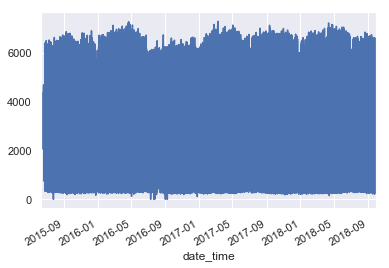

In [45]:
df_reduced['traffic_volume'].plot()

In [46]:
df_reduced.loc['2015-01':].head(10)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-06-11 20:00:00,0,287.586,Rain,2886
2015-06-12 18:00:00,0,297.543,Clear,4380
2015-06-12 20:00:00,0,292.061,Clear,3095
2015-06-12 21:00:00,0,292.061,Clear,3299
2015-06-13 21:00:00,0,294.840,Clouds,3040
2015-06-13 23:00:00,0,293.137,Clouds,2051
2015-06-14 20:00:00,0,296.064,Rain,2909
2015-06-19 18:00:00,0,299.007,Clear,4681
2015-06-20 18:00:00,0,295.369,Rain,4045


In [ ]:
#df_reduced.loc['2015-06':'2015-09', 'traffic_volume']

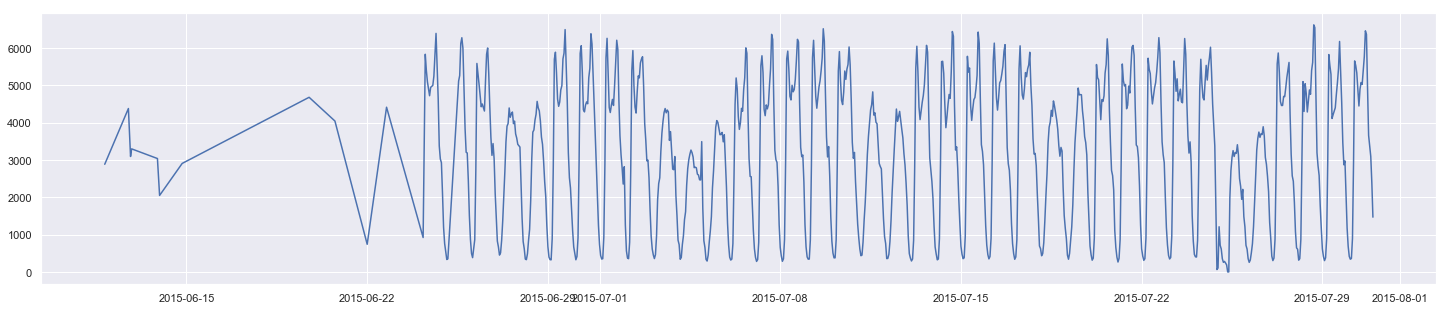

In [48]:
plt.figure(figsize=(25,5))
plt.plot(df_reduced.loc['2015-06-11':'2015-07-30', 'traffic_volume'])
#plt.xticks(rotation=90);

In [49]:
df_reduced = df_reduced.loc['2015-07':]
df_reduced.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


We can consider data starting __from July 2015__ because of big gap in data. Still we have quite __long history - over 3 years__.
* check if there are missing indexes
* check if there are duplicates indexes

In [50]:
# if there are missing indexes
df_reduced.index.isnull().sum()

0

## Task 5.1
* create transformer CutDateTransformer which takes dataset from specified date, e.g., 2015-07-01
* extend the pipeline from Task 5

In [51]:
class CutDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cut_date):
        self.cut_date = cut_date
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X.loc[self.cut_date:]

In [52]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit_transform(raw_df).head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


### Duplicates

In [53]:
# duplicated
df_reduced.index.duplicated().sum()

5519

In [54]:
df_reduced[df_reduced.index.duplicated()].head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-04 01:00:00,0,290.88,Mist,851
2015-07-04 02:00:00,0,290.70,Mist,735
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 03:00:00,0,290.49,Mist,341
2015-07-04 03:00:00,0,290.49,Other,341


In [55]:
df_reduced.loc['2015-07-04':'2015-07-05'].head(8)

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-04 00:00:00,0,291.76,Other,1512
2015-07-04 01:00:00,0,290.88,Other,851
2015-07-04 01:00:00,0,290.88,Mist,851
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 02:00:00,0,290.70,Mist,735
2015-07-04 02:00:00,0,290.70,Other,735
2015-07-04 03:00:00,0,290.49,Other,341
2015-07-04 03:00:00,0,290.49,Mist,341


### Duplicates: volume traffic is the same but the weather changed. Duplicates can be removed.

In [56]:
# condition to filter out duplicated values
not_duplicated = ~df_reduced.index.duplicated()
df_no_duplicates = df_reduced.loc[not_duplicated]
df_no_duplicates.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


In [57]:
df_no_duplicates.index.duplicated().sum()

0

In [58]:
df_no_duplicates.shape

(26528, 4)

## Task 6
* create transformer to remove duplicated indexes

In [59]:
class RemoveDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        not_duplicated = ~X.index.duplicated()
        return X.loc[not_duplicated]


In [60]:
rdt = RemoveDuplicatesTransformer()
no_dupl_X = rdt.fit_transform(raw_df)
no_dupl_X.index.duplicated().sum()

0

# Missing values

Missing values for existing indexes

In [61]:
df_no_duplicates.isna().sum()

holiday           0
temp              0
weather_main      0
traffic_volume    0
dtype: int64

In [62]:
df_no_duplicates.shape

(26528, 4)

Missing indexes <br>
E.g., 01-01, 01-02, 01-04, 01-05 => here 01-03 is missing index

In [63]:
# all the time steps from min to max date within our dataset with specified frequency
full_idx = pd.date_range(start=df_no_duplicates.index.min(), end=df_no_duplicates.index.max(), freq='1H')
print(full_idx[:5])

DatetimeIndex(['2015-07-01 00:00:00', '2015-07-01 01:00:00',
               '2015-07-01 02:00:00', '2015-07-01 03:00:00',
               '2015-07-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')


In [64]:
len(full_idx)

28512

In [65]:
# missing indexes - those which present in full_idx but absent in the dataset
missing_indexes = ~full_idx.isin(df_no_duplicates.index) # True if missing otherwise False
print(f'Number of missing values/indexes: {np.sum(missing_indexes)}') 
print(f'Pecentage form entire dataset: {np.mean(missing_indexes)}')

Number of missing values/indexes: 1984
Pecentage form entire dataset: 0.06958473625140292


In [66]:
missing_indexes

array([False, False, False, ..., False, False, False])

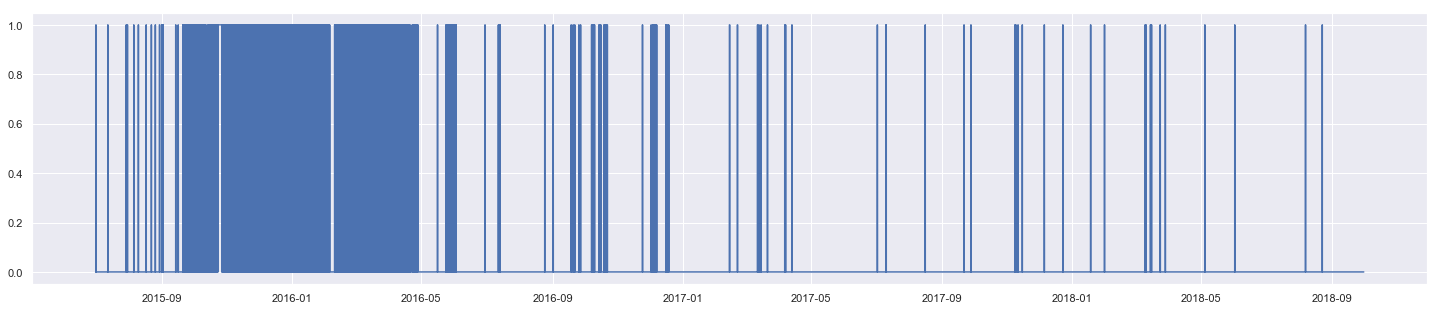

In [67]:
missing_indexes_df = pd.Series(missing_indexes, index=full_idx)
plt.figure(figsize=(25,5))
plt.plot(missing_indexes_df);

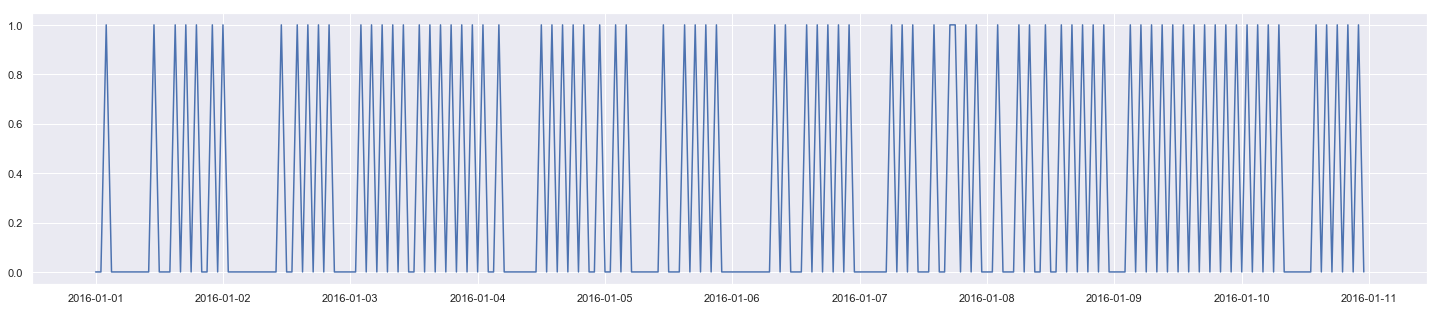

In [68]:
plt.figure(figsize=(25,5))
plt.plot(missing_indexes_df.loc['2016-01-01':'2016-01-10']);

## Resample Data

### Hourly
We are interested in daily values. But before this, we need to fill missing hourly values otherwise during the aggregation (especially sum) the daily value will be significantly underestimated. 


In [69]:
df_no_duplicates.head()

,holiday,temp,weather_main,traffic_volume
date_time,,,,
2015-07-01 00:00:00,0,289.20,Clear,737
2015-07-01 01:00:00,0,289.40,Clear,444
2015-07-01 02:00:00,0,289.19,Clear,347
2015-07-01 03:00:00,0,288.74,Rain,356
2015-07-01 04:00:00,0,288.07,Clear,936


In [70]:
df_no_duplicates.index = pd.to_datetime(df_no_duplicates.index)

In [71]:
df_res_H = pd.DataFrame()

# interpolate missing values
df_res_H['traffic_volume'] = df_no_duplicates['traffic_volume'].resample('1H').mean().interpolate()
df_res_H['temp'] = df_no_duplicates['temp'].resample('1H').mean().interpolate()

# impute by fill forward
df_res_H['weather_main'] = df_no_duplicates['weather_main'].resample('1H').ffill()
df_res_H['holiday'] = df_no_duplicates['holiday'].resample('1H').ffill()

In [72]:
df_res_H.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01 00:00:00,737.0,289.20,Clear,0
2015-07-01 01:00:00,444.0,289.40,Clear,0
2015-07-01 02:00:00,347.0,289.19,Clear,0
2015-07-01 03:00:00,356.0,288.74,Rain,0
2015-07-01 04:00:00,936.0,288.07,Clear,0


In [73]:
print(pd.infer_freq(df_res_H.index))

H


## Task 7
* create transformer for hourly resampling the dataset
* extend the pipeline from task 5 by duplicates transformer and hourly resampling
* check if the transformed dataset has H frequency

In [74]:
class HourlyResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        df_res_H = pd.DataFrame()
        X.index = pd.to_datetime(X.index)
        df_res_H['traffic_volume'] = X['traffic_volume'].resample('1H').mean().interpolate()
        df_res_H['temp'] = X['temp'].resample('1H').mean().interpolate()

        # impute by fill forward
        df_res_H['weather_main'] = X['weather_main'].resample('1H').ffill()
        df_res_H['holiday'] = X['holiday'].resample('1H').ffill()
        return df_res_H

In [75]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer()), 
    ('duplicates', RemoveDuplicatesTransformer()), 
    ('hourly_resample', HourlyResampleTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('cut_date', CutDateTransformer(cut_date='2015-07-01')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])), ('holiday', HolidayTransformer()), ('main_weather', WeatherTransformer()), ('duplicates', RemoveDuplicatesTransformer()), ('hourly_resample', HourlyResampleTransformer())])

In [76]:
df_transformed = pipeline.transform(raw_df)
df_transformed.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01 00:00:00,737.0,289.20,Clear,0
2015-07-01 01:00:00,444.0,289.40,Clear,0
2015-07-01 02:00:00,347.0,289.19,Clear,0
2015-07-01 03:00:00,356.0,288.74,Rain,0
2015-07-01 04:00:00,936.0,288.07,Clear,0


In [77]:
print(pd.infer_freq(df_transformed.index))

H


### Daily
During the downsampling process (from Hourlly to Daily) the aggregation method should be selected for each column:
* traffic volume - sum during the day
* temperature - average during the day
* weather - the most often during the day
* holiday - max of the day (if there is 1 during the day than 1 otherwise 0)

In [78]:
df_res_H.loc['2015-09-01']['weather_main'].value_counts()

Other    12
Rain      6
Clear     5
Mist      1
Name: weather_main, dtype: int64

In [81]:
x = [1,1,2,2,2,3,0]
stats.mode(x)[0][0]

2

In [82]:
df_res_D = pd.DataFrame()

df_res_D['traffic_volume'] = df_res_H['traffic_volume'].resample('1D').sum()
df_res_D['temp'] = df_res_H['temp'].resample('1D').mean()

df_res_D['weather_main'] = df_res_H['weather_main'].resample('1D').apply(lambda x: stats.mode(x)[0][0])
df_res_D['holiday'] = df_res_H['holiday'].resample('1D').max()

In [83]:
df_res_D.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0


In [84]:
print(pd.infer_freq(df_res_D.index))

D


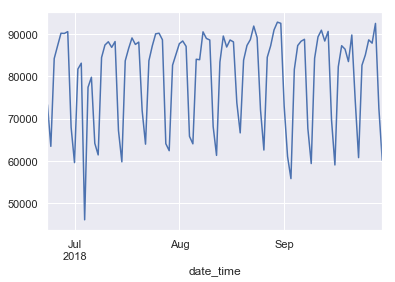

In [85]:
df_res_D['traffic_volume'][-100:].plot()

## Task 8
* create transformer for daily resampling the dataset
* extend the pipeline from task 7
* check if the transformed dataset has D frequency

In [86]:
class DailyResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        df_res_D = pd.DataFrame()

        df_res_D['traffic_volume'] = X['traffic_volume'].resample('1D').sum()
        df_res_D['temp'] = X['temp'].resample('1D').mean()

        df_res_D['weather_main'] = X['weather_main'].resample('1D').apply(lambda x: stats.mode(x)[0][0])
        df_res_D['holiday'] = X['holiday'].resample('1D').max()
        return df_res_D

In [87]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer()), 
    ('duplicates', RemoveDuplicatesTransformer()), 
    ('hourly_resample', HourlyResampleTransformer()), 
    ('daily_resample', DailyResampleTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('cut_date', CutDateTransformer(cut_date='2015-07-01')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])), ('holiday', HolidayTransformer()), ('main_weather', WeatherTransformer()), ('duplicates', RemoveDuplicatesTransformer()), ('hourly_resample', HourlyResampleTransformer()), ('daily_resample', DailyResampleTransformer())])

In [88]:
transformed_df = pipeline.transform(raw_df)
transformed_df.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0


In [89]:
print(pd.infer_freq(transformed_df.index))

D


## Outliers
We want to cut upper 0.5% of values as well as lower 0.5% of values to get rid of suspicious values.

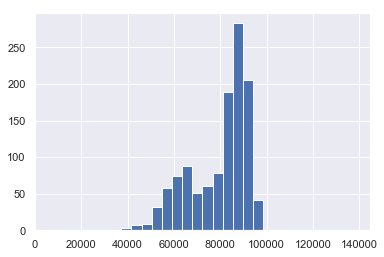

41187.0 97374.0


In [90]:
y = df_res_D['traffic_volume']
y.hist(bins=30)
plt.show()
low, high = round(np.percentile(y, 0.5)), round(np.percentile(y, 99.5))
print(low, high)

In [91]:
low_99, high_99 = round(np.percentile(y, 1)), round(np.percentile(y, 99))
print(low_99, high_99)

45279.0 96861.0


In [93]:
def f(low, high, x):
    if x < low:
        x = low
    elif x > high:
        x = high
    return x

y_no_outliers = y.copy()
y_no_outliers = y_no_outliers.apply(lambda x: f(low, high, x))
print((y != y_no_outliers).sum())

12


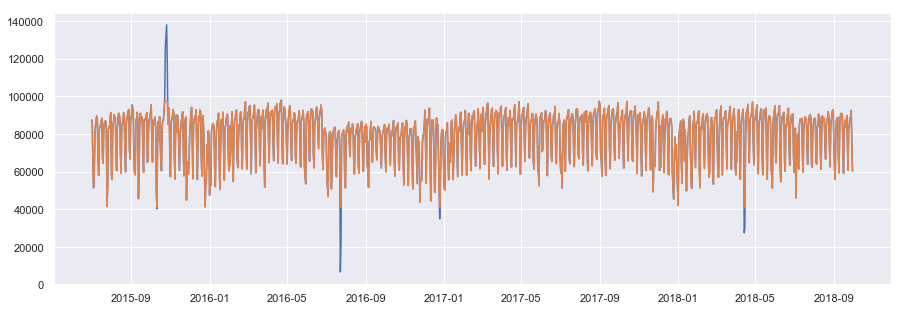

In [94]:
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(y_no_outliers)
plt.show()

In [95]:
df_res_D['traffic_volume'] = y_no_outliers

## Task 9
* implement transformer __VolumeRemoveOutliersTransformer__ with passing percentiles like [1, 99]
* extend the previous pipeline

In [96]:
class VolumeRemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, percentiles=[1,99]):
        self.percentiles = percentiles
        self.boundaries = None
        self.col = 'traffic_volume'
        
        
    def fit( self, X, y = None ):
        lower = round(np.percentile(X[self.col], self.percentiles[0]))
        upper = round(np.percentile(X[self.col], self.percentiles[1]))
        self.boundaries = [lower, upper]
          
        return self 
    
    def transform( self, X, y = None ):
        # low, high = self.percentile
        # X['traffic_volume'] = [np.clip(x, low, high) for x in X['traffic_volume']]
        def f(low, high, x):
            if x < low:
                x = low
            elif x > high:
                x = high
            return x
        low = self.boundaries[0]
        high = self.boundaries[1]
        X[self.col] = X[self.col].apply(lambda x: f(low, high, x))
    
        return X

In [97]:
VolumeRemoveOutliersTransformer().fit_transform(raw_df).head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,None,287.586,0.0,0.0,92,Rain,light rain,2886.0
1,2015-06-12 18:00:00,None,297.543,0.0,0.0,0,Clear,Sky is Clear,4380.0
2,2015-06-12 20:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3095.0
3,2015-06-12 21:00:00,None,292.061,0.0,0.0,8,Clear,sky is clear,3299.0
4,2015-06-13 21:00:00,None,294.840,0.0,0.0,76,Clouds,broken clouds,3040.0


In [98]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer()), 
    ('duplicates', RemoveDuplicatesTransformer()), 
    ('hourly_resample', HourlyResampleTransformer()), 
    ('daily_resample', DailyResampleTransformer()), 
    ('remove_outliers', VolumeRemoveOutliersTransformer())
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('cut_date', CutDateTransformer(cut_date='2015-07-01')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])), ('holiday', HolidayTransformer()), ('main_weather', Weat...lyResampleTransformer()), ('remove_outliers', VolumeRemoveOutliersTransformer(percentiles=[1, 99]))])

In [99]:
transformed_df = pipeline.transform(raw_df)
transformed_df.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0


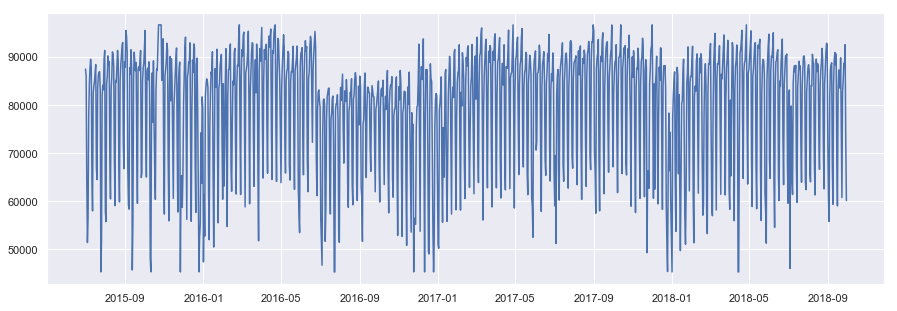

In [100]:
plt.figure(figsize=(15,5))
plt.plot(transformed_df['traffic_volume']);

# Features Engineering
1. date related features
    - month
    - day of month
    - day of week
    - is a day a weekend?
    - is a day a holiday? (we have it already)
    - is it a beginning/end of the month?
    - is it a beginning/end of the quarter?
2. trend & seasonality
3. differencing
4. percentage change
5. rolling statistics for above mentioned
    - moving average for last 3,5,7,14 days
    - moving standard deviation/max/median for 3/5/7/14/... days
6. lagged values for above mentioned
    - lagged values of volume traffic with lag of 3/5/7/14/... days
    - lagged values of rolling statistics with lag of 3/5/7/14/... days
7. differencing of rolling statistics and lagged values 
etc.
    

### Date-related features

In [101]:
df_features = df_res_D.copy()
df_features.head()

,traffic_volume,temp,weather_main,holiday
date_time,,,,
2015-07-01,87440.0,290.721250,Clear,0
2015-07-02,86035.0,291.581667,Clear,0
2015-07-03,64366.0,293.042500,Clear,1
2015-07-04,51400.0,295.751667,Other,0
2015-07-05,56563.0,297.172083,Clear,0


In [102]:
def generate_date_features(df_features):
    df_features['date'] = pd.to_datetime(df_features.index)
    df_features['month'] = df_features['date'].dt.month
    df_features['month_day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
    df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
    return df_features

In [103]:
df_features = generate_date_features(df_features)
df_features.head()

,traffic_volume,temp,weather_main,holiday,date,month,month_day,day_of_week,is_weekend
date_time,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,2015-07-01,7,1,2,0
2015-07-02,86035.0,291.581667,Clear,0,2015-07-02,7,2,3,0
2015-07-03,64366.0,293.042500,Clear,1,2015-07-03,7,3,4,0
2015-07-04,51400.0,295.751667,Other,0,2015-07-04,7,4,5,1
2015-07-05,56563.0,297.172083,Clear,0,2015-07-05,7,5,6,1


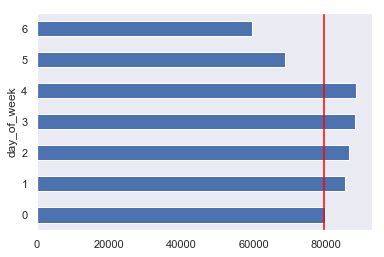

In [104]:
# depending on the day of week
df_features.groupby('day_of_week').mean()['traffic_volume'].plot.barh()
plt.vlines(df_features['traffic_volume'].mean(), ymin=-1, ymax=7, color='red')
plt.grid()

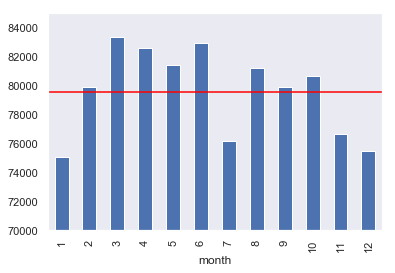

In [107]:
# depending on the month
df_features.groupby('month').mean()['traffic_volume'].plot.bar()
plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=12, color='red')
plt.ylim(70000, 85000)
plt.grid()

(70000, 85000)

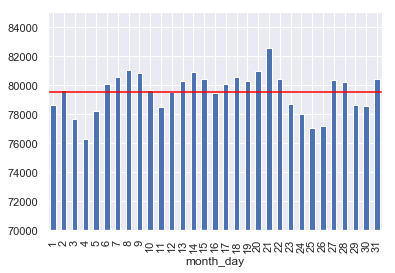

In [110]:
# depending on the day of month
df_features.groupby('month_day').mean()['traffic_volume'].plot.bar()
plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=32, color='red')
plt.ylim(70000, 85000)

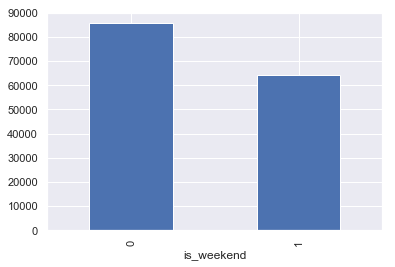

In [111]:
df_features.groupby('is_weekend').mean()['traffic_volume'].plot.bar()


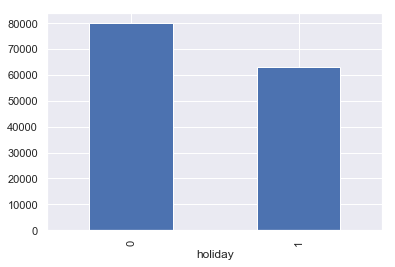

In [112]:
df_features.groupby('holiday').mean()['traffic_volume'].plot.bar()

### Conclusion for date related features:
* feature __'month_day'__ doesn't show any impact on the traffic volume so we may remove them.
* other features should be kept.

In [113]:
df_features = df_features.drop(['month_day', 'date'], axis=1)
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend
date_time,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0
2015-07-02,86035.0,291.581667,Clear,0,7,3,0
2015-07-03,64366.0,293.042500,Clear,1,7,4,0
2015-07-04,51400.0,295.751667,Other,0,7,5,1
2015-07-05,56563.0,297.172083,Clear,0,7,6,1


### Trend and Seasonality

In [114]:
series = df_features['traffic_volume']

In [115]:
result = seasonal_decompose(series)

In [116]:
df_features['seasonality'] = result.seasonal
df_features['trend'] = result.trend

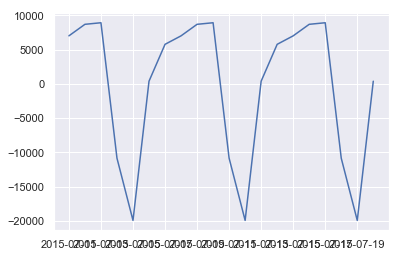

In [117]:
plt.plot(df_features['seasonality'][:20])

In [118]:
result.seasonal.head(10)

date_time
2015-07-01     7009.368540
2015-07-02     8691.407213
2015-07-03     8920.239941
2015-07-04   -10848.711567
2015-07-05   -19931.251691
2015-07-06      388.238616
2015-07-07     5770.708946
2015-07-08     7009.368540
2015-07-09     8691.407213
2015-07-10     8920.239941
Freq: D, Name: traffic_volume, dtype: float64

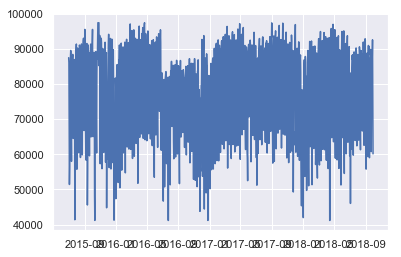

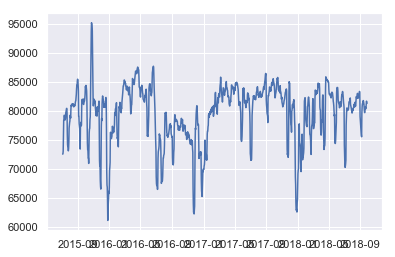

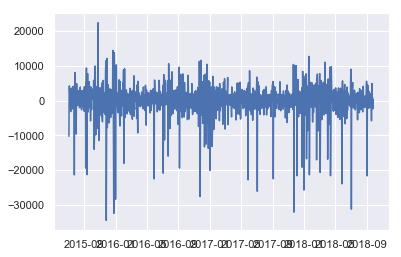

In [119]:
plt.plot(series)
plt.show()

plt.plot(df_features['trend'])
plt.show()

plt.plot(result.resid)
plt.show()

In [120]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend
date_time,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000


### Rolling statistics

In [121]:
for i in range(2,8): # from 2 to 7
    df_features[f'mov_avg_{i}'] = df_features['traffic_volume'].rolling(window=i).mean()
    df_features[f'mov_std_{i}'] = df_features['traffic_volume'].rolling(window=i).std()

In [122]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_3,mov_std_3,mov_avg_4,mov_std_4,mov_avg_5,mov_std_5,mov_avg_6,mov_std_6,mov_avg_7,mov_std_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,79280.333333,12935.281610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,67267.000000,17498.790158,72310.25,17489.308741,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,57443.000000,6527.640385,64591.00,15257.206232,69160.8,16703.35645,NaN,NaN,NaN,NaN


In [123]:
df_features.shape

(1188, 21)

### Lagged Values

In [124]:
for i in range(1, 8): # from 0 to 8
    df_features[f'traffic_lag_{i}'] = df_features['traffic_volume'].shift(i)

In [125]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_std_6,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,NaN,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,NaN,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,NaN,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN


In [126]:
df_features.shape

(1188, 28)

### Categorical Column - __weather_main__


(70000, 85000)

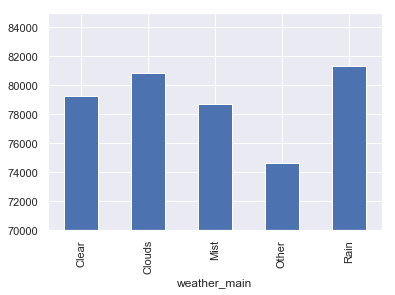

In [129]:
df_features.groupby('weather_main').mean()['traffic_volume'].plot.bar()
#plt.grid()
plt.ylim(70000, 85000)

(65000, 85000)

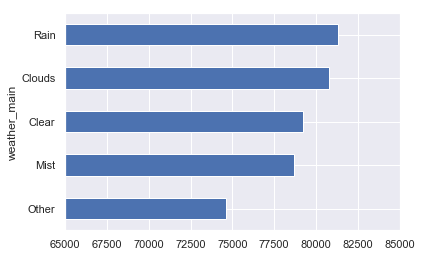

In [130]:
df_features.groupby('weather_main').mean()['traffic_volume'].sort_values().plot.barh()
plt.xlim(65000, 85000)

### Two ways of encoding:
* One Hot Encoding
* Ordinal Encoding with taking into consideration the correlation with the target

The second option gives the only dimension instead of 5 for OHE.
Mapping will be like this: 
* Rain - 1
* Clouds - 2
* Clear - 3
* Mist - 4
* Other - 5

In [131]:
def map_weather(weather):
    d = {'Rain': 1, 
        'Clouds': 2, 
        'Clear': 3, 
        'Mist': 4, 
        'Other': 5}
    return d[weather]
    
df_features['weather'] = df_features['weather_main'].apply(lambda x: map_weather(x))

In [132]:
df_features[['weather', 'weather_main']].head()

,weather,weather_main
date_time,,
2015-07-01,3,Clear
2015-07-02,3,Clear
2015-07-03,3,Clear
2015-07-04,5,Other
2015-07-05,3,Clear


In [133]:
df_features.head()

,traffic_volume,temp,weather_main,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,Clear,0,7,2,0,7009.368540,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-02,86035.0,291.581667,Clear,0,7,3,0,8691.407213,NaN,86737.5,...,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-03,64366.0,293.042500,Clear,1,7,4,0,8920.239941,NaN,75200.5,...,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN,3
2015-07-04,51400.0,295.751667,Other,0,7,5,1,-10848.711567,72533.285714,57883.0,...,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN,5
2015-07-05,56563.0,297.172083,Clear,0,7,6,1,-19931.251691,72559.000000,53981.5,...,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN,3


In [134]:
df_features = df_features.drop('weather_main', axis=1)
df_features.head()

,traffic_volume,temp,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,mov_std_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,290.721250,0,7,2,0,7009.368540,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-02,86035.0,291.581667,0,7,3,0,8691.407213,NaN,86737.5,993.485028,...,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-03,64366.0,293.042500,1,7,4,0,8920.239941,NaN,75200.5,15322.296842,...,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN,3
2015-07-04,51400.0,295.751667,0,7,5,1,-10848.711567,72533.285714,57883.0,9168.346525,...,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN,5
2015-07-05,56563.0,297.172083,0,7,6,1,-19931.251691,72559.000000,53981.5,3650.792311,...,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN,3


In [135]:
df_features.isna().sum()

traffic_volume    0
temp              0
holiday           0
month             0
day_of_week       0
is_weekend        0
seasonality       0
trend             6
mov_avg_2         1
mov_std_2         1
mov_avg_3         2
mov_std_3         2
mov_avg_4         3
mov_std_4         3
mov_avg_5         4
mov_std_5         4
mov_avg_6         5
mov_std_6         5
mov_avg_7         6
mov_std_7         6
traffic_lag_1     1
traffic_lag_2     2
traffic_lag_3     3
traffic_lag_4     4
traffic_lag_5     5
traffic_lag_6     6
traffic_lag_7     7
weather           0
dtype: int64

In [136]:
df_features.shape

(1188, 28)

In [137]:
df_features_na = df_features.dropna()
df_features_na.head()

,traffic_volume,temp,holiday,month,day_of_week,is_weekend,seasonality,trend,mov_avg_2,mov_std_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-08,87620.0,290.508333,0,7,2,0,7009.368540,78370.142857,85943.0,2371.636144,...,72559.000000,14956.835160,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,87440.0,3
2015-07-09,89488.0,293.528333,0,7,3,0,8691.407213,78571.000000,88554.0,1320.875467,...,73052.285714,15521.633599,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,3
2015-07-10,87818.0,296.469167,0,7,4,0,8920.239941,79247.285714,88653.0,1180.868325,...,76402.571429,15861.538995,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,3
2015-07-11,65173.0,296.281250,0,7,5,1,-10848.711567,79197.857143,76495.5,16012.433060,...,78370.142857,12802.381620,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,2
2015-07-12,57969.0,298.381875,0,7,6,1,-19931.251691,78801.000000,61571.0,5093.997252,...,78571.000000,12408.186787,65173.0,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,2


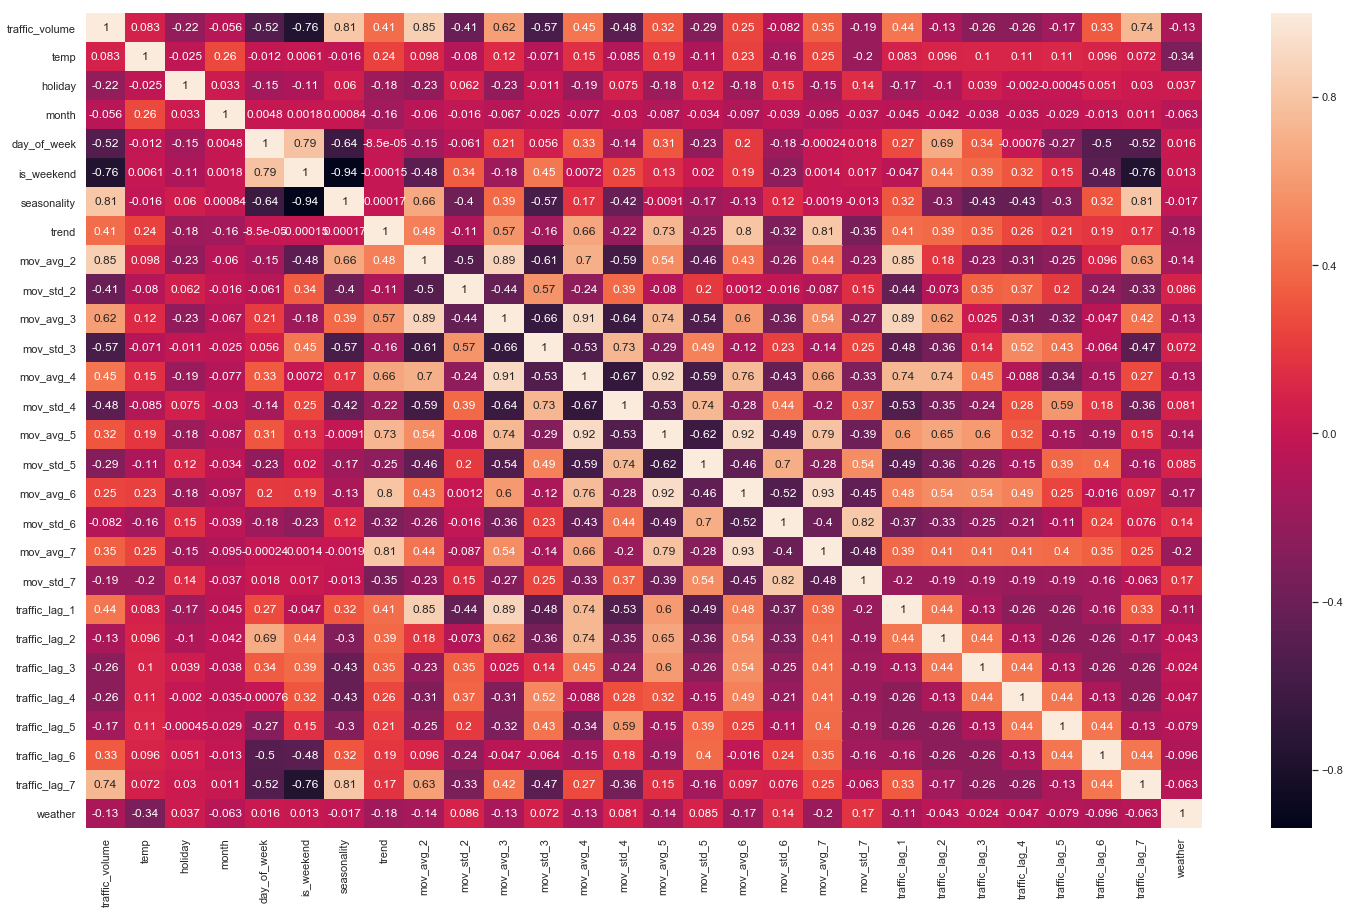

In [138]:
plt.figure(figsize=(25,15))
sns.heatmap(df_features_na.corr(), annot=True)

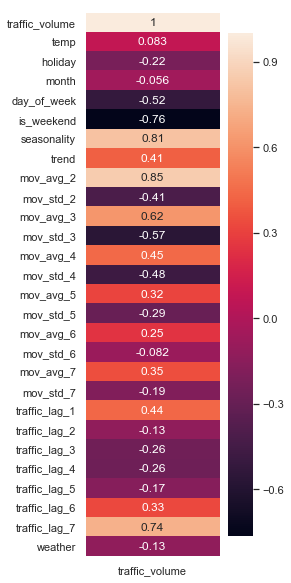

In [139]:
plt.figure(figsize=(3,10))
sns.heatmap(pd.DataFrame(df_features_na.corr()['traffic_volume']), annot=True)

In [140]:
a = df_features_na.corr()['traffic_volume']
print(a[a>0.6].index.tolist())
print(a[a<-0.6].index.tolist())

['traffic_volume', 'seasonality', 'mov_avg_2', 'mov_avg_3', 'traffic_lag_7']
['is_weekend']


In [141]:
# better solution - create transformer for all the features
# then create another trnasformer for features selection based on the correlation coeffcient

## Task 10
* implement FeatureEngineering transformer which computes following features with correlation absolute value higher than __0.5__
* extend the pipeline
* remove exisitng columns which are not correlated: holiday, weather

In [142]:
print(a[a>0.5].index.tolist())
print(a[a<-0.5].index.tolist())

['traffic_volume', 'seasonality', 'mov_avg_2', 'mov_avg_3', 'traffic_lag_7']
['day_of_week', 'is_weekend', 'mov_std_3']


In [143]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        df_features = X.copy()
        
        # seasonality
        df_features['seasonality'] = seasonal_decompose(df_features['traffic_volume']).seasonal
        
        # 'mov_avg_2', 'mov_avg_3', 'mov_std_3'
        df_features[f'mov_avg_2'] = df_features['traffic_volume'].rolling(window=2).mean()
        df_features[f'mov_avg_3'] = df_features['traffic_volume'].rolling(window=3).mean()
        df_features[f'mov_std_3'] = df_features['traffic_volume'].rolling(window=3).std()
        
        # 'traffic_lag_7'
        df_features['traffic_lag_7'] = df_features['traffic_volume'].shift(7)
        
        # 'day_of_week', 'is_weekend'
        df_features['date'] = df_features.index
        df_features['day_of_week'] = df_features['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
        df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]),1,0)
        
        
        # drop missing values and unnecessary columns
        df_features = df_features.dropna()
        df_features = df_features.drop('date', axis=1)
    
        return df_features

In [144]:
columns_to_remove = ['rain_1h', 'snow_1h', 'clouds_all', 'weather_description']
columns_to_remove_2 = ['weather_main', 'holiday', 'temp']

steps = [
    ('make_ts', MakeTSTransformer(date_column='date_time')),
    ('cut_date', CutDateTransformer('2015-07-01')),
    ('drop_columns', RemoveColumnsTransformer(columns_to_remove=columns_to_remove)),
    ('holiday', HolidayTransformer()), 
    ('main_weather', WeatherTransformer()), 
    ('duplicates', RemoveDuplicatesTransformer()), 
    ('hourly_resample', HourlyResampleTransformer()), 
    ('daily_resample', DailyResampleTransformer()), 
    ('remove_outliers', VolumeRemoveOutliersTransformer()), 
    ('features', FeatureEngineeringTransformer()), 
    ('drop_columns_again', RemoveColumnsTransformer(columns_to_remove=columns_to_remove_2))
    
        ]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(memory=None,
     steps=[('make_ts', MakeTSTransformer(date_column='date_time')), ('cut_date', CutDateTransformer(cut_date='2015-07-01')), ('drop_columns', RemoveColumnsTransformer(columns_to_remove=['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])), ('holiday', HolidayTransformer()), ('main_weather', Weat...op_columns_again', RemoveColumnsTransformer(columns_to_remove=['weather_main', 'holiday', 'temp']))])

Final pipeline can be modified => remove steps: 'holiday', 'main_weather', modify resampling steps etc. 

In [145]:
pipeline.transform(raw_df).head()

,traffic_volume,seasonality,mov_avg_2,mov_avg_3,mov_std_3,traffic_lag_7,day_of_week,is_weekend
date_time,,,,,,,,
2015-07-08,87620.0,6939.746950,85943.0,83183.000000,5066.076292,87440.0,2,0
2015-07-09,89488.0,8632.319351,88554.0,87124.666667,2646.004031,86035.0,3,0
2015-07-10,87818.0,8917.815720,88653.0,88308.666667,1026.119551,64366.0,4,0
2015-07-11,65173.0,-10767.566969,76495.5,80826.333333,13581.876098,51400.0,5,1
2015-07-12,57969.0,-19824.617659,61571.0,70320.000000,15575.923953,56563.0,6,1


# Models Training


In [146]:
df_final = pipeline.transform(raw_df)
df_final.head()

,traffic_volume,seasonality,mov_avg_2,mov_avg_3,mov_std_3,traffic_lag_7,day_of_week,is_weekend
date_time,,,,,,,,
2015-07-08,87620.0,6939.746950,85943.0,83183.000000,5066.076292,87440.0,2,0
2015-07-09,89488.0,8632.319351,88554.0,87124.666667,2646.004031,86035.0,3,0
2015-07-10,87818.0,8917.815720,88653.0,88308.666667,1026.119551,64366.0,4,0
2015-07-11,65173.0,-10767.566969,76495.5,80826.333333,13581.876098,51400.0,5,1
2015-07-12,57969.0,-19824.617659,61571.0,70320.000000,15575.923953,56563.0,6,1


In [147]:
#df_final = df_features_na.copy()
X = df_final.drop('traffic_volume', axis=1)
y = df_final['traffic_volume']

In [148]:
def mse(y_pred, y_true):
    return round(np.sqrt(mean_squared_error(y_pred, y_true)))

In [ ]:
X.shape

### Train Test Split

In [149]:
# 20% for validation
split_index = int(y.shape[0] * 0.8)
split_index

944

In [150]:
y_train, y_test = y[:split_index], y[split_index:]

## Naive Forecast

In [151]:
def naive_forecast(ts, period):
    actual = ts[period:]
    preds = ts.shift(period)[period:]
    
    return mse(actual, preds)

In [152]:
naive_forecast(y_test, period=7)

8913.0

### Baseline Performance

In [153]:
for i in range(1,8):
    print(f'{i}: {naive_forecast(y_test, period=i)}')

1: 13705.0
2: 19671.0
3: 20713.0
4: 20823.0
5: 19939.0
6: 14812.0
7: 8913.0


For ML model to be useful, it should have better performance than Naive Forecast.

## Data Preparation

In [ ]:
X.head(2)

In [ ]:
y.head(2)

In [154]:
def prepare_data(X, y, period, split_ratio=0.8):
    # define index border between train and test
    split_index = int(0.8*X.shape[0])
    
    # shift the features; remove missing values by slicing; target should be aligned with features
    X_shift = X.shift(period)[period:]
    y_shift = y[period:]
    
    # split original features and target on index
    X_train, X_test = X_shift[:split_index], X_shift[split_index:]
    y_train, y_test = y_shift[:split_index], y_shift[split_index:]
    
    return X_train, y_train, X_test, y_test

In [155]:
#df_final = df_features_na.copy()
X = df_final.drop('traffic_volume', axis=1)
y = df_final['traffic_volume']

## Linear models
Assumptions:
* data are scaled
* data are normally distribited
* data are not multicolinear
* no outliers

### Ridge Regression

In [156]:
# pipeline definition
steps = [
    ('transform', PowerTransformer(method='yeo-johnson')), 
    ('scale', MinMaxScaler()), 
    ('pca', PCA(n_components=0.9)), # to remove highly correlated features
    ('ridge', Ridge())
]
pipeline = Pipeline(steps=steps)

ridge_preds = []
for period in range(1,8):
    X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.8)

    params = {'ridge__alpha': [0, 0.01, 0.5, 0.9, 1.0]}
    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
    grid_search.fit(X_train, y_train)
    ridge_model = grid_search.best_estimator_
    score = mse(ridge_model.predict(X_test), y_test)
    pred = ridge_model.predict(X.tail(1))[0]
    ridge_preds.append(pred)
    print(f'Period: {period}')
    print(f'Forecast: {round(pred)} +/- {score}')

Period: 1
Forecast: 68766.0 +/- 10553.0
Period: 2
Forecast: 81617.0 +/- 9468.0
Period: 3
Forecast: 85666.0 +/- 9732.0
Period: 4
Forecast: 87494.0 +/- 11307.0
Period: 5
Forecast: 87245.0 +/- 8179.0
Period: 6
Forecast: 75045.0 +/- 8548.0
Period: 7
Forecast: 61599.0 +/- 6433.0


1: 13705.0
2: 19671.0
3: 20713.0
4: 20823.0
5: 19939.0
6: 14812.0
7: 8913.0

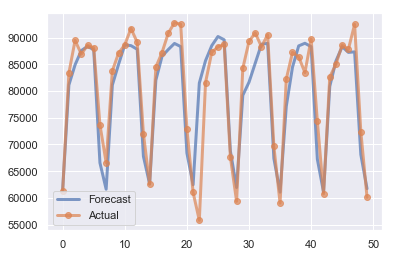

In [157]:

preds = ridge_model.predict(X_test)
plt.plot(preds[-50:], label='Forecast', linewidth=3, alpha=0.7)
plt.plot(y_test.values[-50:], 'o-', label='Actual', linewidth=3, alpha=0.7)
plt.legend();

## Task 11
* implement the training process and predictions using Lasso model

### Lasso

In [158]:
# pipeline definition
steps = [
    ('transform', PowerTransformer(method='yeo-johnson')), 
    ('scale', MinMaxScaler()), 
    ('lasso', Lasso())
]
pipeline = Pipeline(steps=steps)
lasso_preds = []
for period in range(1,8):
    X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.8)

    params = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 1.0]}
    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
    grid_search.fit(X_train, y_train)
    lasso_model = grid_search.best_estimator_
    score = mse(lasso_model.predict(X_test), y_test)
    pred = lasso_model.predict(X.tail(1))[0]
    lasso_preds.append(pred)
    print(f'Period: {period}')
    print(f'Forecast: {round(pred)} +/- {score}')

Period: 1
Forecast: 71746.0 +/- 10323.0
Period: 2
Forecast: 79579.0 +/- 9221.0
Period: 3
Forecast: 88981.0 +/- 9176.0
Period: 4
Forecast: 94625.0 +/- 9685.0
Period: 5
Forecast: 91091.0 +/- 7357.0
Period: 6
Forecast: 70559.0 +/- 6599.0
Period: 7
Forecast: 61375.0 +/- 6407.0


Period: 1
Forecast: 68766.0 +/- 10553.0
Period: 2
Forecast: 81617.0 +/- 9468.0
Period: 3
Forecast: 85666.0 +/- 9732.0
Period: 4
Forecast: 87494.0 +/- 11307.0
Period: 5
Forecast: 87245.0 +/- 8179.0
Period: 6
Forecast: 75045.0 +/- 8548.0
Period: 7
Forecast: 61599.0 +/- 6433.0

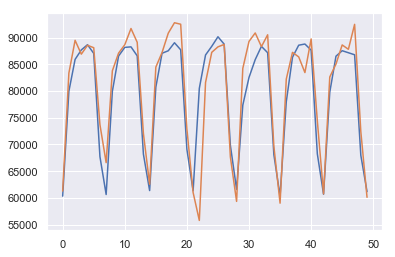

In [159]:
preds = lasso_model.predict(X_test)
plt.plot(preds[-50:])
plt.plot(y_test.values[-50:])

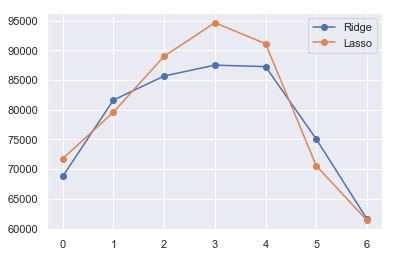

In [160]:
plt.plot(ridge_preds, 'o-', label='Ridge')
plt.plot(lasso_preds, 'o-', label='Lasso')
plt.legend();

## Task 12 
* try non-linear model and compare the results

## Residuals diagnostic

Mean: 640.3813657078426 STD: 6388.6318493281615


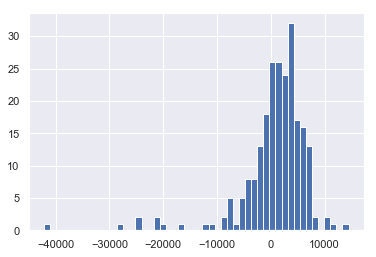

In [161]:
errors = y_test - preds
print(f'Mean: {errors.mean()} STD: {errors.std()}')
plt.hist(errors, bins=50);

In average, model underestimates a little (y_test is bigger than forecasts by __640__ instead of 0).

# Ideas for improvements
* differenced target instead of target
* non-linear algorithms (SVR, Trees, Neural Network)